In [1]:
import numpy as np
import numpy.linalg as la
import pyopencl as cl
import pyopencl.array as cl_array
from tqdm import tqdm
import time
from contextlib import contextmanager
from functools import reduce
import math
from pprint import pprint
import matplotlib.pyplot as plt
import sys
import threading

In [2]:
platforms = cl.get_platforms()

def get_platform_info(platform):
    keys = [
        "EXTENSIONS",
        "EXTENSIONS_WITH_VERSION",
        "HOST_TIMER_RESOLUTION",
        "NAME",
        "NUMERIC_VERSION",
        "PROFILE",
        "VENDOR",
        "VERSION",
    ]
    info = {}
    for key in keys:
        try:
            value = platform.get_info(getattr(cl.platform_info, key))
            info.setdefault(key.lower(), value)
        except:
            pass
    for key in ("extensions",):
        values = info.get(key, None)
        if values:
            values = values.split(" ")
            values = [v.strip() for v in values]
            values = [v for v in values if len(v) > 0]
            info[key] = set(values)
    return info

platform_infos = list(map(get_platform_info, platforms))
if len(platforms) > 1:
    print(f"> Listing platforms ({len(platforms)})")
    pprint(platform_infos)

platform_index = 0
platform = platforms[platform_index]
platform_info = platform_infos[platform_index]

print(f"> Selected platform ({platform_index})")
pprint(platform_info)

def get_device_info(device):
    keys = [
        "ADDRESS_BITS",
        "ATOMIC_FENCE_CAPABILITIES",
        "ATOMIC_MEMORY_CAPABILITIES",
        "ATTRIBUTE_ASYNC_ENGINE_COUNT_NV",
        "AVAILABLE",
        "AVAILABLE_ASYNC_QUEUES_AMD",
        "BOARD_NAME_AMD",
        "BUILT_IN_KERNELS",
        "BUILT_IN_KERNELS_WITH_VERSION",
        "COMPILER_AVAILABLE",
        "COMPUTE_CAPABILITY_MAJOR_NV",
        "COMPUTE_CAPABILITY_MINOR_NV",
        "DEVICE_ENQUEUE_CAPABILITIES",
        "DOUBLE_FP_CONFIG",
        "DRIVER_VERSION",
        "ENDIAN_LITTLE",
        "ERROR_CORRECTION_SUPPORT",
        "EXECUTION_CAPABILITIES",
        "EXTENSIONS",
        "EXTENSIONS_WITH_VERSION",
        "EXT_MEM_PADDING_IN_BYTES_QCOM",
        "GENERIC_ADDRESS_SPACE_SUPPORT",
        "GFXIP_MAJOR_AMD",
        "GFXIP_MINOR_AMD",
        "GLOBAL_FREE_MEMORY_AMD",
        "GLOBAL_MEM_CACHELINE_SIZE",
        "GLOBAL_MEM_CACHE_SIZE",
        "GLOBAL_MEM_CACHE_TYPE",
        "GLOBAL_MEM_CHANNELS_AMD",
        "GLOBAL_MEM_CHANNEL_BANKS_AMD",
        "GLOBAL_MEM_CHANNEL_BANK_WIDTH_AMD",
        "GLOBAL_MEM_SIZE",
        "GLOBAL_VARIABLE_PREFERRED_TOTAL_SIZE",
        "GPU_OVERLAP_NV",
        "HALF_FP_CONFIG",
        "HOST_UNIFIED_MEMORY",
        "ILS_WITH_VERSION",
        "IL_VERSION",
        "IMAGE2D_MAX_HEIGHT",
        "IMAGE2D_MAX_WIDTH",
        "IMAGE3D_MAX_DEPTH",
        "IMAGE3D_MAX_HEIGHT",
        "IMAGE3D_MAX_WIDTH",
        "IMAGE_BASE_ADDRESS_ALIGNMENT",
        "IMAGE_MAX_ARRAY_SIZE",
        "IMAGE_MAX_BUFFER_SIZE",
        "IMAGE_PITCH_ALIGNMENT",
        "IMAGE_SUPPORT",
        "INTEGRATED_MEMORY_NV",
        "KERNEL_EXEC_TIMEOUT_NV",
        "LINKER_AVAILABLE",
        "LOCAL_MEM_BANKS_AMD",
        "LOCAL_MEM_SIZE",
        "LOCAL_MEM_SIZE_PER_COMPUTE_UNIT_AMD",
        "LOCAL_MEM_TYPE",
        "MAX_ATOMIC_COUNTERS_EXT",
        "MAX_CLOCK_FREQUENCY",
        "MAX_COMPUTE_UNITS",
        "MAX_CONSTANT_ARGS",
        "MAX_CONSTANT_BUFFER_SIZE",
        "MAX_GLOBAL_VARIABLE_SIZE",
        "MAX_MEM_ALLOC_SIZE",
        "MAX_NUM_SUB_GROUPS",
        "MAX_ON_DEVICE_EVENTS",
        "MAX_ON_DEVICE_QUEUES",
        "MAX_PARAMETER_SIZE",
        "MAX_PIPE_ARGS",
        "MAX_READ_IMAGE_ARGS",
        "MAX_READ_WRITE_IMAGE_ARGS",
        "MAX_SAMPLERS",
        "MAX_WORK_GROUP_SIZE",
        "MAX_WORK_GROUP_SIZE_AMD",
        "MAX_WORK_ITEM_DIMENSIONS",
        "MAX_WORK_ITEM_SIZES",
        "MAX_WRITE_IMAGE_ARGS",
        "MEM_BASE_ADDR_ALIGN",
        "ME_VERSION_INTEL",
        "MIN_DATA_TYPE_ALIGN_SIZE",
        "NAME",
        "NATIVE_VECTOR_WIDTH_CHAR",
        "NATIVE_VECTOR_WIDTH_DOUBLE",
        "NATIVE_VECTOR_WIDTH_FLOAT",
        "NATIVE_VECTOR_WIDTH_HALF",
        "NATIVE_VECTOR_WIDTH_INT",
        "NATIVE_VECTOR_WIDTH_LONG",
        "NATIVE_VECTOR_WIDTH_SHORT",
        "NON_UNIFORM_WORK_GROUP_SUPPORT",
        "NUMERIC_VERSION",
        "NUM_SIMULTANEOUS_INTEROPS_INTEL",
        "OPENCL_C_ALL_VERSIONS",
        "OPENCL_C_FEATURES",
        "OPENCL_C_VERSION",
        "PAGE_SIZE_QCOM",
        "PARENT_DEVICE",
        "PARTITION_AFFINITY_DOMAIN",
        "PARTITION_MAX_SUB_DEVICES",
        "PARTITION_PROPERTIES",
        "PARTITION_TYPE",
        "PCIE_ID_AMD",
        "PCI_BUS_ID_NV",
        "PCI_DOMAIN_ID_NV",
        "PCI_SLOT_ID_NV",
        "PIPE_MAX_ACTIVE_RESERVATIONS",
        "PIPE_MAX_PACKET_SIZE",
        "PIPE_SUPPORT",
        "PLATFORM",
        "PREFERRED_CONSTANT_BUFFER_SIZE_AMD",
        "PREFERRED_GLOBAL_ATOMIC_ALIGNMENT",
        "PREFERRED_INTEROP_USER_SYNC",
        "PREFERRED_LOCAL_ATOMIC_ALIGNMENT",
        "PREFERRED_PLATFORM_ATOMIC_ALIGNMENT",
        "PREFERRED_VECTOR_WIDTH_CHAR",
        "PREFERRED_VECTOR_WIDTH_DOUBLE",
        "PREFERRED_VECTOR_WIDTH_FLOAT",
        "PREFERRED_VECTOR_WIDTH_HALF",
        "PREFERRED_VECTOR_WIDTH_INT",
        "PREFERRED_VECTOR_WIDTH_LONG",
        "PREFERRED_VECTOR_WIDTH_SHORT",
        "PREFERRED_WORK_GROUP_SIZE_AMD",
        "PREFERRED_WORK_GROUP_SIZE_MULTIPLE",
        "PRINTF_BUFFER_SIZE",
        "PROFILE",
        "PROFILING_TIMER_OFFSET_AMD",
        "PROFILING_TIMER_RESOLUTION",
        "QUEUE_ON_DEVICE_MAX_SIZE",
        "QUEUE_ON_DEVICE_PREFERRED_SIZE",
        "QUEUE_ON_DEVICE_PROPERTIES",
        "QUEUE_ON_HOST_PROPERTIES",
        "QUEUE_PROPERTIES",
        "REFERENCE_COUNT",
        "REGISTERS_PER_BLOCK_NV",
        "SIMD_INSTRUCTION_WIDTH_AMD",
        "SIMD_PER_COMPUTE_UNIT_AMD",
        "SIMD_WIDTH_AMD",
        "SIMULTANEOUS_INTEROPS_INTEL",
        "SINGLE_FP_CONFIG",
        "SPIR_VERSIONS",
        "SUB_GROUP_INDEPENDENT_FORWARD_PROGRESS",
        "SVM_CAPABILITIES",
        "THREAD_TRACE_SUPPORTED_AMD",
        "TOPOLOGY_AMD",
        "TYPE",
        "VENDOR",
        "VENDOR_ID",
        "VERSION",
        "WARP_SIZE_NV",
        "WAVEFRONT_WIDTH_AMD",
        "WORK_GROUP_COLLECTIVE_FUNCTIONS_SUPPORT",
    ]
    info = {}
    for key in keys:
        try:
            value = device.get_info(getattr(cl.device_info, key))
            info.setdefault(key.lower(), value)
        except:
            pass
    for key in ("extensions",):
        values = info.get(key, None)
        if values:
            values = values.split(" ")
            values = [v.strip() for v in values]
            values = [v for v in values if len(v) > 0]
            info[key] = set(values)
    return info

devices = platform.get_devices()
device_infos = list(map(get_device_info, devices))
if len(devices) > 1:
    print(f"> Listing devices ({len(devices)})")
    pprint(device_infos)

device_index = 0
device = devices[device_index]
device_info = device_infos[device_index]

print(f"> Selected device ({device_index})")
pprint(device_info)

context = cl.Context(devices=[device])

> Selected platform (0)
{'extensions': {'cl_amd_event_callback',
                'cl_amd_offline_devices',
                'cl_khr_d3d10_sharing',
                'cl_khr_d3d11_sharing',
                'cl_khr_dx9_media_sharing',
                'cl_khr_icd'},
 'host_timer_resolution': 100,
 'name': 'AMD Accelerated Parallel Processing',
 'profile': 'FULL_PROFILE',
 'vendor': 'Advanced Micro Devices, Inc.',
 'version': 'OpenCL 2.1 AMD-APP (3628.0)'}
> Selected device (0)
{'address_bits': 64,
 'available': 1,
 'available_async_queues_amd': 2,
 'board_name_amd': 'AMD Radeon(TM) Graphics',
 'built_in_kernels': '',
 'compiler_available': 1,
 'double_fp_config': 63,
 'driver_version': '3628.0 (PAL,LC)',
 'endian_little': 1,
 'error_correction_support': 0,
 'execution_capabilities': 1,
 'extensions': {'cl_amd_copy_buffer_p2p',
                'cl_amd_device_attribute_query',
                'cl_amd_media_ops',
                'cl_amd_media_ops2',
                'cl_amd_planar_yuv',
       

In [3]:
class NanoTimer:
    def __init__(self):
        self.start_ns = None
        self.end_ns = None
    
    def __enter__(self):
        self.start_ns = time.time_ns()
        return self

    def __exit__(self, *args):
        self.end_ns = time.time_ns()        

    def get_delta_ns(self):
        return self.end_ns - self.start_ns

In [4]:
program_source = f"""
    __kernel void update_E(
        __global float *E, __global const float *H, __global float *cH, 
        __global float *A_0, __global float *A_1,
        int Nx, int Ny, int Nz
    ) {{
        // a = 1/2 * Co/ek * sigma_k * dxyz * Z0
        // a_0 = (1-a)/(1+a)
        // a_1 = Co/ek * 1/(1+a)
    
        const int ix = get_global_id(0);
        const int iy = get_global_id(1);
        const int iz = get_global_id(2);

        if (ix >= Nx) return;
        if (iy >= Ny) return;
        if (iz >= Nz) return;

        const int n_dims = 3;
        const int Nzy = Nz*Ny;
        const int i0 = iz + iy*Nz + ix*Nzy;
        const int i = n_dims*i0;
        const int dz = n_dims*(((iz+1) % Nz) + iy*Nz + ix*Nzy);
        const int dy = n_dims*(iz + ((iy+1) % Ny)*Nz + ix*Nzy);
        const int dx = n_dims*(iz + iy*Nz + ((ix+1) % Nx)*Nzy);

        // curl(H)
        const float dHz_dy = H[dy+2]-H[i+2];
        const float dHy_dz = H[dz+1]-H[i+1];
        const float dHx_dz = H[dz+0]-H[i+0];
        const float dHz_dx = H[dx+2]-H[i+2];
        const float dHy_dx = H[dx+1]-H[i+1]; 
        const float dHx_dy = H[dy+0]-H[i+0];
        const float cHx = dHz_dy-dHy_dz;
        const float cHy = dHx_dz-dHz_dx;
        const float cHz = dHy_dx-dHx_dy;

        const float a_0 = A_0[i0];
        const float a_1 = A_1[i0];

        E[i+0] = a_0*(E[i+0] + a_1*cHx);
        E[i+1] = a_0*(E[i+1] + a_1*cHy);
        E[i+2] = a_0*(E[i+2] + a_1*cHz);
    
        cH[i+0] = cHx;
        cH[i+1] = cHy;
        cH[i+2] = cHz;
        return;
    }}

    __kernel void update_H(
        __global const float *E, __global float *H, __global float *cE,
        __global float *A_0,
        int Nx, int Ny, int Nz
    ) {{
        // a_0 = Co/ek
        const int ix = get_global_id(0);
        const int iy = get_global_id(1);
        const int iz = get_global_id(2);

        if (ix >= Nx) return;
        if (iy >= Ny) return;
        if (iz >= Nz) return;

        const int n_dims = 3;
        const int Nzy = Nz*Ny;
        const int i0 = iz + iy*Nz + ix*Nzy;
        const int i = n_dims*i0;
        const int dz = n_dims*(((iz-1+Nz) % Nz) + iy*Nz + ix*Nzy);
        const int dy = n_dims*(iz + ((iy-1+Ny) % Ny)*Nz + ix*Nzy);
        const int dx = n_dims*(iz + iy*Nz + ((ix-1+Nx) % Nx)*Nzy);

        // curl(E)
        const float dEz_dy = E[i+2]-E[dy+2];
        const float dEy_dz = E[i+1]-E[dz+1];
        const float dEx_dz = E[i+0]-E[dz+0];
        const float dEz_dx = E[i+2]-E[dx+2];
        const float dEy_dx = E[i+1]-E[dx+1]; 
        const float dEx_dy = E[i+0]-E[dy+0];
        const float cEx = dEz_dy-dEy_dz;
        const float cEy = dEx_dz-dEz_dx;
        const float cEz = dEy_dx-dEx_dy;

        const float a_0 = A_0[i0];
        H[i+0] = H[i+0] - a_0*cEx;
        H[i+1] = H[i+1] - a_0*cEy;
        H[i+2] = H[i+2] - a_0*cEz;

        cE[i+0] = cEx;
        cE[i+1] = cEy;
        cE[i+2] = cEz;
        return;
    }}
"""

gpu_program = cl.Program(context, program_source).build()

C:\Users\acidi\Coding\Projects\wgpu_compute_experiments\pyopencl\venv\Lib\site-packages\pyopencl\cache.py:496: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(


In [5]:
max_compute_units = device_info["max_compute_units"]
workgroups_per_compute_unit = 2048
max_workgroup_threads = device_info["max_work_group_size"]
max_mem_alloc_size = device_info["max_mem_alloc_size"]

sizeof_type = 4
max_global_threads = max_compute_units*workgroups_per_compute_unit*max_workgroup_threads
max_global_threads = min(max_global_threads*sizeof_type, max_mem_alloc_size) // sizeof_type
max_global_threads = (max_global_threads//max_workgroup_threads) * max_workgroup_threads
print(max_global_threads, max_workgroup_threads)

rng = np.random.default_rng()
grid_size = (16, 256, 512)
#grid_size = (17, 107, 128)
Nx,Ny,Nz = grid_size
n_dims = 3
data_shape = grid_size + (n_dims,)
# workgroup_size = (1,1,256)
workgroup_size = (1,1,256)
max_workgroup_size = device_info["max_work_group_size"]
workgroup_size_count = reduce(lambda x,y: x*y, workgroup_size, 1)
assert(workgroup_size_count <= max_workgroup_size)

dispatch_size = [math.ceil(x/y) for x,y in zip(grid_size, workgroup_size)]
# assert(all([x % y == 0 for x,y in zip(grid_size, workgroup_size)]))
global_size = [x*y for x,y in zip(dispatch_size, workgroup_size)]
total_cells = reduce(lambda x,y: x*y, grid_size, n_dims)

print("=== Parameters ===")
print(f"grid_size={grid_size}")
print(f"workgroup_size={workgroup_size}")
print(f"dispatch_size={dispatch_size}")
print(f"global_size={global_size}")
print(f"total_cells={total_cells}")

c_0 = 299792458
mu_0 = 4*math.pi*10**-7 # vacuum permeability
e_0 = 1/(mu_0 * c_0**2)
Z_0 = mu_0*c_0

d_xyz = 1e-3
dt = 1e-12

e_k = np.full(grid_size, e_0, dtype=np.float64)
sigma_k = np.full(grid_size, 0, dtype=np.float64)

sigma_0 = 1e8
barrier_pos = [slice(0,Nx), slice(30,90), slice(30,40)]
sigma_k[*barrier_pos] = sigma_0

alpha = sigma_k

a_0 = 1/(1 + sigma_k / e_k * dt)
a_1 = 1/((1+alpha)*e_k) * (1/d_xyz) * dt
b_0 = 1/np.full(grid_size, mu_0) * (1/d_xyz) * dt

a_0 = a_0.astype(np.float32)
a_1 = a_1.astype(np.float32)
b_0 = b_0.astype(np.float32)

E_cpu = np.zeros(data_shape, dtype=np.float32)
H_cpu = np.zeros(data_shape, dtype=np.float32)

width = 10
# A = np.cos(np.linspace(-np.pi, np.pi, width*2, endpoint=True)) + 1
# A = A*0.1
A = 0.53836 - 0.46164*np.cos(np.linspace(0, np.pi*2, width*2, endpoint=True))
#A = 1

signal_pos = [slice(5,6), slice(0,Ny), slice(Nz//2-width, Nz//2+width)]
E_cpu[*signal_pos,0] = A
#E_cpu[*signal_pos,2] = A
#H_cpu[:] = E_cpu[:]/Z0
#H_cpu[:] = E_cpu[:]
H_cpu[*signal_pos,0] = -A/Z_0 / d_xyz

cH_cpu = np.zeros(data_shape, dtype=np.float32)
cE_cpu = np.zeros(data_shape, dtype=np.float32)

3145728 256
=== Parameters ===
grid_size=(16, 256, 512)
workgroup_size=(1, 1, 256)
dispatch_size=[16, 256, 2]
global_size=[16, 256, 512]
total_cells=6291456


In [6]:
if False:
    with cl.CommandQueue(context) as queue:
        a_0_gpu = cl_array.zeros(queue, grid_size, np.float32)
        a_1_gpu = cl_array.zeros(queue, grid_size, np.float32)
        b_0_gpu = cl_array.zeros(queue, grid_size, np.float32)
        E_gpu = cl_array.zeros(queue, data_shape, np.float32)
        H_gpu = cl_array.zeros(queue, data_shape, np.float32)
    with cl.CommandQueue(context) as queue:
        a_0_gpu.set(a_0, queue=queue)
        a_1_gpu.set(a_1, queue=queue)
        b_0_gpu.set(b_0, queue=queue)
        E_gpu.set(E_cpu, queue=queue)
        H_gpu.set(H_cpu, queue=queue)
else:
    with cl.CommandQueue(context) as queue:
        a_0_gpu = cl_array.to_device(queue, a_0)
        a_1_gpu = cl_array.to_device(queue, a_1)
        b_0_gpu = cl_array.to_device(queue, b_0)
        E_gpu = cl_array.to_device(queue, E_cpu)
        H_gpu = cl_array.to_device(queue, H_cpu)
        cE_gpu = cl_array.to_device(queue, cE_cpu)
        cH_gpu = cl_array.to_device(queue, cH_cpu)

In [7]:
E_cpu_out = np.zeros(E_cpu.shape, dtype=E_cpu.dtype)
H_cpu_out = np.zeros(H_cpu.shape, dtype=H_cpu.dtype)
cE_cpu_out = np.zeros(cE_cpu.shape, dtype=cE_cpu.dtype)
cH_cpu_out = np.zeros(cH_cpu.shape, dtype=cH_cpu.dtype)

  0%|          | 0/4096 [00:00<?, ?it/s]

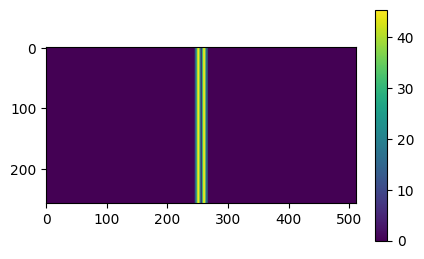

  0%|          | 1/4096 [00:00<28:34,  2.39it/s]

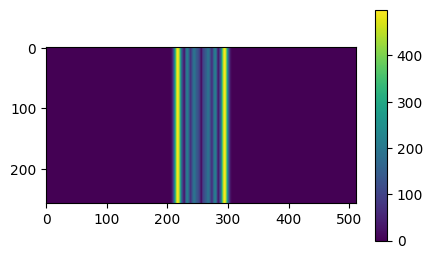

  3%|▎         | 129/4096 [00:01<00:33, 117.04it/s]

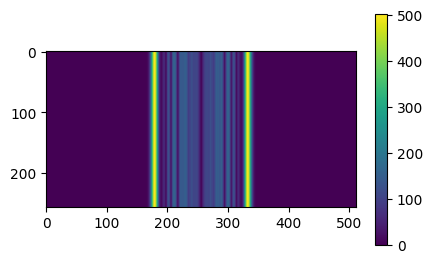

  6%|▋         | 257/4096 [00:02<00:27, 139.81it/s]

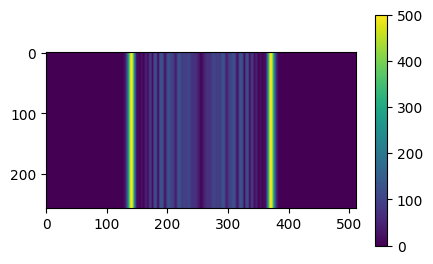

  9%|▉         | 385/4096 [00:02<00:24, 149.56it/s]

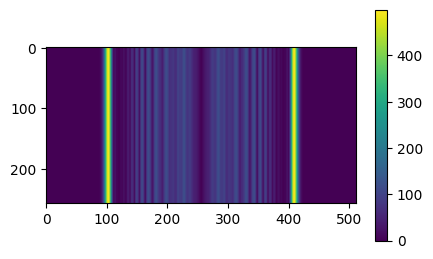

 13%|█▎        | 513/4096 [00:03<00:23, 152.18it/s]

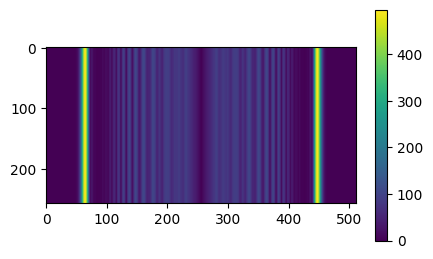

 19%|█▊        | 764/4096 [00:04<00:15, 217.78it/s]

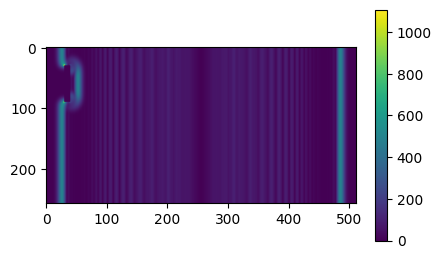

 20%|█▉        | 814/4096 [00:05<00:20, 161.58it/s]

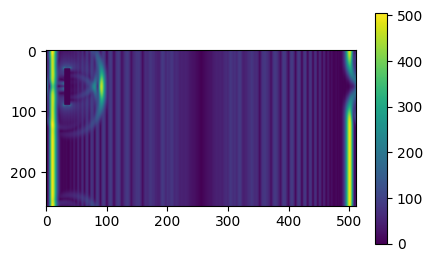

 22%|██▏       | 897/4096 [00:05<00:22, 143.59it/s]

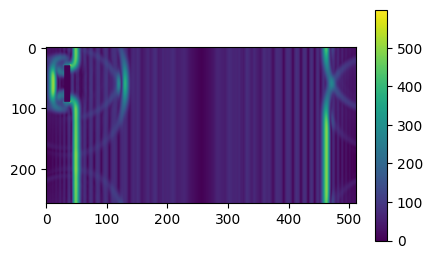

 25%|██▌       | 1025/4096 [00:06<00:21, 142.42it/s]

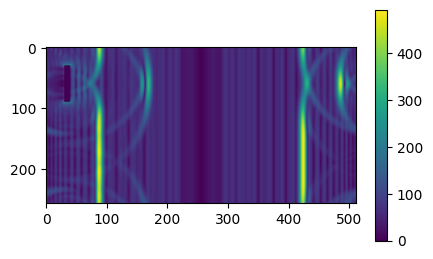

 28%|██▊       | 1153/4096 [00:07<00:19, 149.04it/s]

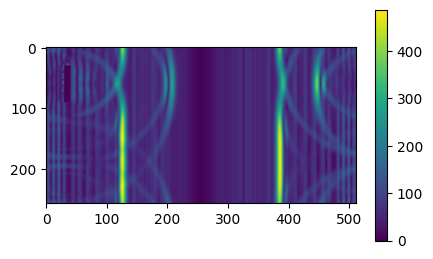

 31%|███▏      | 1281/4096 [00:08<00:18, 154.59it/s]

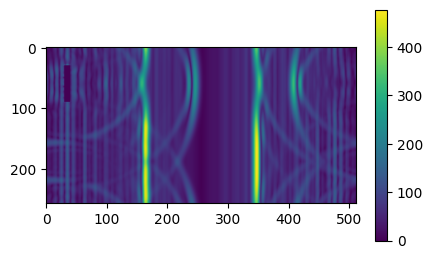

 37%|███▋      | 1513/4096 [00:09<00:12, 206.07it/s]

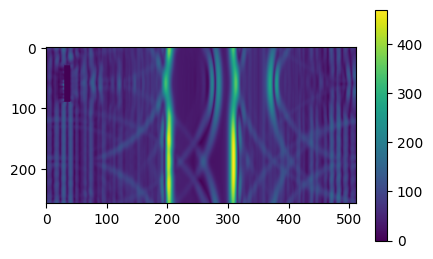

 38%|███▊      | 1558/4096 [00:10<00:16, 154.54it/s]

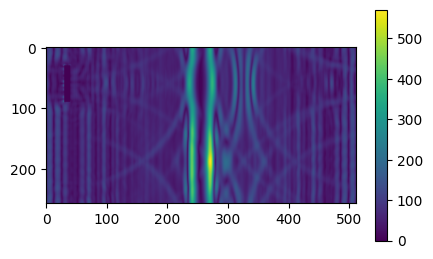

 41%|████      | 1665/4096 [00:10<00:16, 150.51it/s]

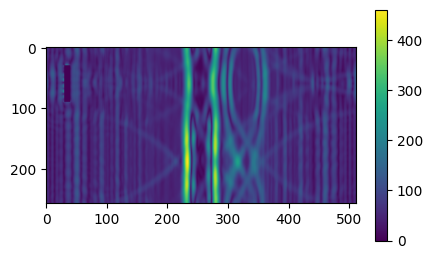

 44%|████▍     | 1793/4096 [00:11<00:14, 154.47it/s]

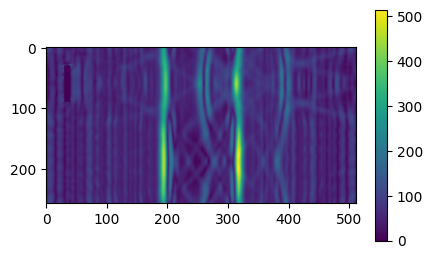

 47%|████▋     | 1921/4096 [00:12<00:13, 157.67it/s]

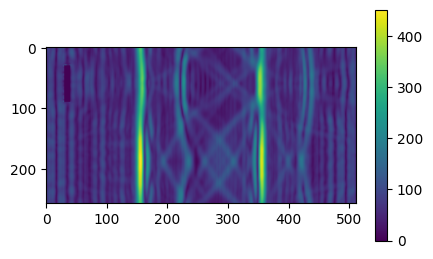

 52%|█████▏    | 2139/4096 [00:13<00:09, 201.58it/s]

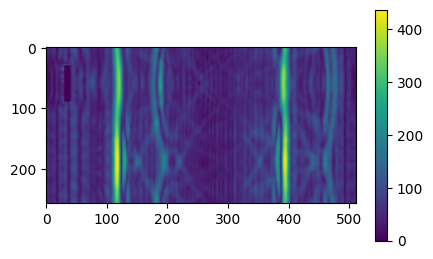

 53%|█████▎    | 2181/4096 [00:13<00:12, 149.41it/s]

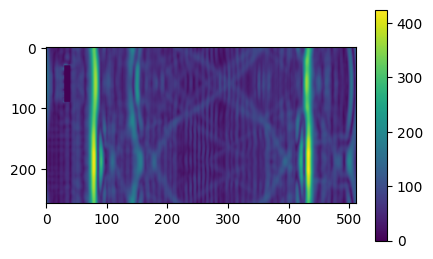

 56%|█████▋    | 2305/4096 [00:14<00:11, 155.16it/s]

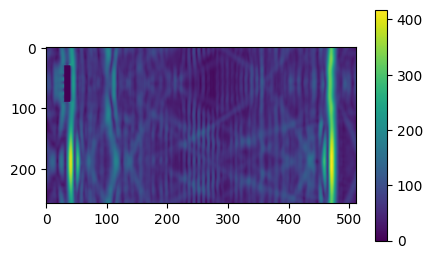

 59%|█████▉    | 2433/4096 [00:15<00:10, 157.73it/s]

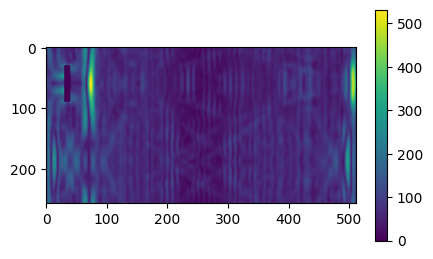

 63%|██████▎   | 2561/4096 [00:16<00:10, 151.15it/s]

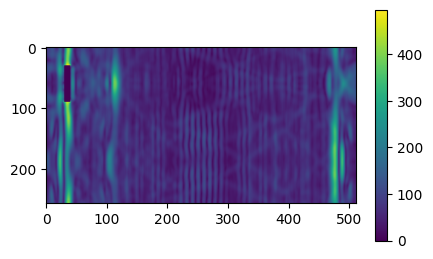

 66%|██████▌   | 2689/4096 [00:17<00:09, 154.82it/s]

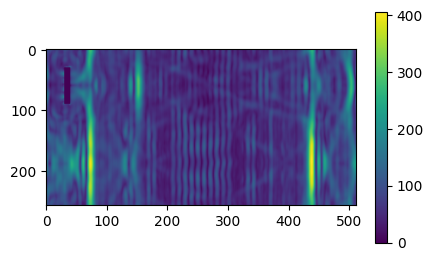

 69%|██████▉   | 2817/4096 [00:17<00:08, 158.53it/s]

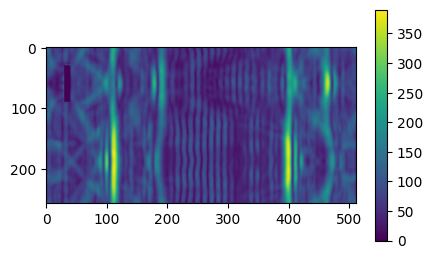

 72%|███████▏  | 2945/4096 [00:18<00:07, 160.11it/s]

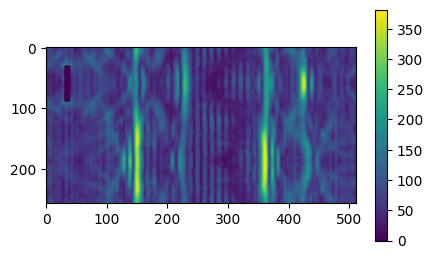

 75%|███████▌  | 3073/4096 [00:19<00:06, 161.87it/s]

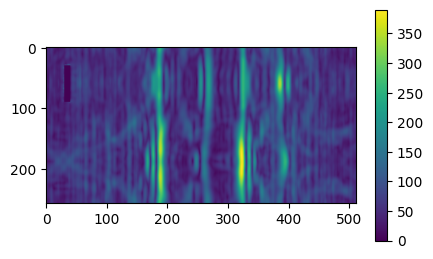

 78%|███████▊  | 3201/4096 [00:20<00:05, 161.98it/s]

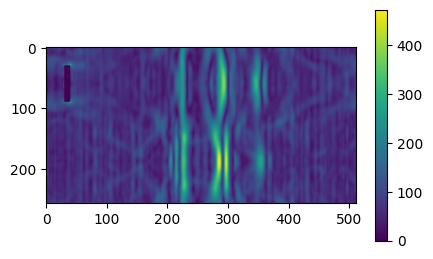

 81%|████████▏ | 3329/4096 [00:21<00:04, 161.88it/s]

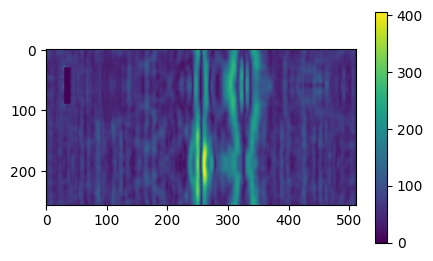

 84%|████████▍ | 3457/4096 [00:21<00:03, 161.87it/s]

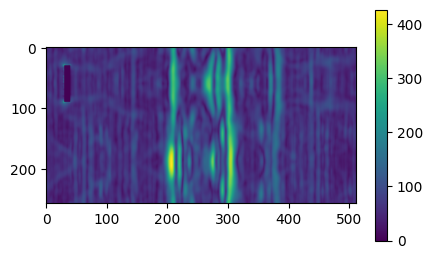

 88%|████████▊ | 3585/4096 [00:22<00:03, 160.64it/s]

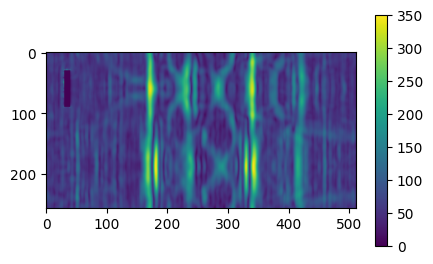

 91%|█████████ | 3713/4096 [00:23<00:02, 160.02it/s]

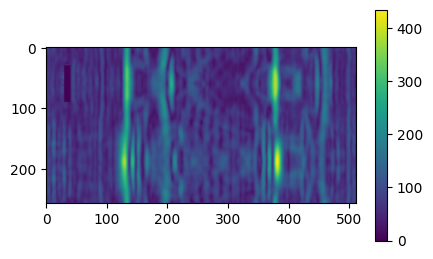

 94%|█████████▍| 3841/4096 [00:24<00:01, 160.13it/s]

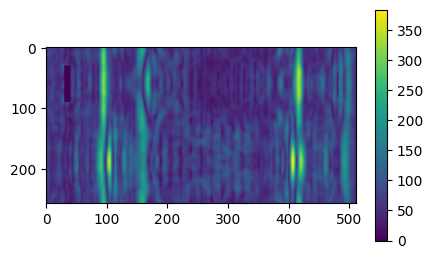

100%|██████████| 4096/4096 [00:25<00:00, 162.47it/s]


gpu_queue_command=25857.165 ms
gpu_submit_time=25857.165 ms
gpu_pass_time=6.313 ms
gpu_cell_rate=996.621 M/s


In [8]:
total_loops = 4096
is_plot = True
plot_rate = 128

kernel_events = []
with NanoTimer() as timer:
    with cl.CommandQueue(context, properties=cl.command_queue_properties.PROFILING_ENABLE) as queue:
        
        for i in tqdm(range(total_loops)):
            ev_update_E = gpu_program.update_E(
                queue, 
                global_size, workgroup_size,
                E_gpu.data, H_gpu.data, cH_gpu.data,
                a_0_gpu.data, a_1_gpu.data,
                *[np.int32(v) for v in grid_size],
            )
            kernel_events.append(('update_E', ev_update_E))
            ev_barrier_E = cl.enqueue_barrier(queue, wait_for=[ev_update_E])
            kernel_events.append(('barrier_E', ev_barrier_E))
            ev_update_H = gpu_program.update_H(
                queue, 
                global_size, workgroup_size,
                E_gpu.data, H_gpu.data, cE_gpu.data,
                b_0_gpu.data,
                *[np.int32(v) for v in grid_size],
            )
            kernel_events.append(('update_H', ev_update_H))
            ev_barrier_H = cl.enqueue_barrier(queue, wait_for=[ev_update_H])
            kernel_events.append(('barrier_H', ev_barrier_H))
            queue.flush()

            if is_plot and i % plot_rate == 0:
                ev_copy = cl.enqueue_copy(queue, E_cpu_out, E_gpu.data)
                ev_copy.wait()
                fig = plt.figure(figsize=(5,3))
                data = np.linalg.norm(E_cpu_out, ord=2, axis=3)
                #data = E_cpu_out[5,:,:,0]
                data = np.sum(data, axis=0)
                #data = np.sum(data, axis=0)
                #plt.imshow(data, cmap="jet", vmin=-1, vmax=1)
                #plt.imshow(data, cmap="jet")
                plt.imshow(data)
                plt.colorbar()
                #plt.plot(E_cpu_out[:,150,260,0].squeeze())
                plt.show()
        queue.finish()
gpu_submit_ns = timer.get_delta_ns()
print(f"gpu_queue_command={gpu_submit_ns*1e-6:.3f} ms")

gpu_pass_ns = gpu_submit_ns / total_loops
gpu_cell_rate = total_cells / (gpu_pass_ns*1e-9)

print(f"gpu_submit_time={gpu_submit_ns*1e-6:.3f} ms")
print(f"gpu_pass_time={gpu_pass_ns*1e-6:.3f} ms")
print(f"gpu_cell_rate={gpu_cell_rate*1e-6:.3f} M/s")

In [19]:
with cl.CommandQueue(context) as queue:
    cl.enqueue_copy(queue, E_cpu_out, E_gpu.data)
    cl.enqueue_copy(queue, H_cpu_out, H_gpu.data)
    cl.enqueue_copy(queue, cE_cpu_out, cE_gpu.data)
    cl.enqueue_copy(queue, cH_cpu_out, cH_gpu.data)

<Figure size 500x300 with 0 Axes>

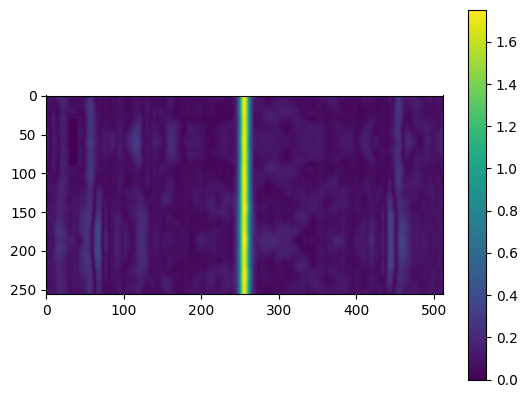

In [20]:
fig = plt.figure(figsize=(5,3))
data = np.linalg.norm(E_cpu_out, ord=2, axis=3)
#data = E_cpu_out[5,:,:,0]
#data = H_cpu_out[:,:,:,2]
#data = E_cpu_out[:,:,:,0]**2 + E_cpu_out[:,:,:,1]**2 + E_cpu_out[:,:,:,2]**2
#data = (E_cpu_out[:,:,:,0]**2 + E_cpu_out[:,:,:,1]**2 + E_cpu_out[:,:,:,2]**2)**0.5
#data = np.sum(data, axis=0)
data = np.sum(np.abs(data), axis=0)
plt.figure()
#plt.imshow(data, cmap="jet", vmin=-1, vmax=1)
plt.imshow(data)
plt.colorbar()
plt.show()

In [21]:
x,y,z = 5, 150, 262
e = E_cpu_out[x,y,z]
h = H_cpu_out[x,y,z]


dEz_dy = E_cpu_out[x,y,z,2] - E_cpu_out[x,(y-1)%Ny,z,2]
dEy_dz = E_cpu_out[x,y,z,1] - E_cpu_out[x,y,(z-1)%Nz,1]
dEx_dz = E_cpu_out[x,y,z,0] - E_cpu_out[x,y,(z-1)%Nz,0]
dEz_dx = E_cpu_out[x,y,z,2] - E_cpu_out[(x-1)%Nx,y,z,2]
dEy_dx = E_cpu_out[x,y,z,1] - E_cpu_out[(x-1)%Nx,y,z,1]
dEx_dy = E_cpu_out[x,y,z,0] - E_cpu_out[x,(y-1)%Ny,z,0]

cEx = dEz_dy-dEy_dz;
cEy = dEx_dz-dEz_dx;
cEz = dEy_dx-dEx_dy;

dHz_dy =  H_cpu_out[x,(y+1)%Ny,z,2] - H_cpu_out[x,y,z,2]
dHy_dz =  H_cpu_out[x,y,(z+1)%Nz,1] - H_cpu_out[x,y,z,1]
dHx_dz =  H_cpu_out[x,y,(z+1)%Nz,0] - H_cpu_out[x,y,z,0]
dHz_dx =  H_cpu_out[(x+1)%Nx,y,z,2] - H_cpu_out[x,y,z,2]
dHy_dx =  H_cpu_out[(x+1)%Nx,y,z,1] - H_cpu_out[x,y,z,1]
dHx_dy =  H_cpu_out[x,(y+1)%Ny,z,0] - H_cpu_out[x,y,z,0]

cHx = dHz_dy-dHy_dz;
cHy = dHx_dz-dHz_dx;
cHz = dHy_dx-dHx_dy;

print(f"[update_E]")
print(f"dHz/dy={dHz_dy:.3e}")
print(f"dHy/dz={dHy_dz:.3e}")
print(f"dHx/dz={dHx_dz:.3e}")
print(f"dHz/dx={dHz_dx:.3e}")
print(f"dHy/dx={dHy_dx:.3e}")
print(f"dHx/dy={dHx_dy:.3e}")
print(f"cH={np.array([cHx,cHy,cHz])}")
print(f"E={e}")

print(f"[update_H]")
print(f"dEz/dy={dEz_dy:.3e}")
print(f"dEy/dz={dEy_dz:.3e}")
print(f"dEx/dz={dEx_dz:.3e}")
print(f"dEz/dx={dEz_dx:.3e}")
print(f"dEy/dx={dEy_dx:.3e}")
print(f"dEx/dy={dEx_dy:.3e}")
print(f"cE={np.array([cEx,cEy,cEz])}")
print(f"H={h}")


[update_E]
dHz/dy=9.602e-08
dHy/dz=-7.700e-06
dHx/dz=5.713e-09
dHz/dx=1.554e-07
dHy/dx=-3.406e-06
dHx/dy=-3.477e-10
cH=[ 7.7958666e-06 -1.4966037e-07 -3.4056154e-06]
E=[ 2.8894690e-01  1.5567709e-04 -6.1842494e-02]
[update_H]
dEz/dy=3.436e-05
dEy/dz=2.343e-05
dEx/dz=-1.175e-01
dEz/dx=-1.237e-01
dEy/dx=3.114e-04
dEx/dy=4.167e-04
cE=[ 1.0929056e-05  6.2041432e-03 -1.0534190e-04]
H=[-3.0897999e-07  4.3917839e-06 -1.2863693e-06]


['queued', 'submit', 'start', 'complete', 'end']


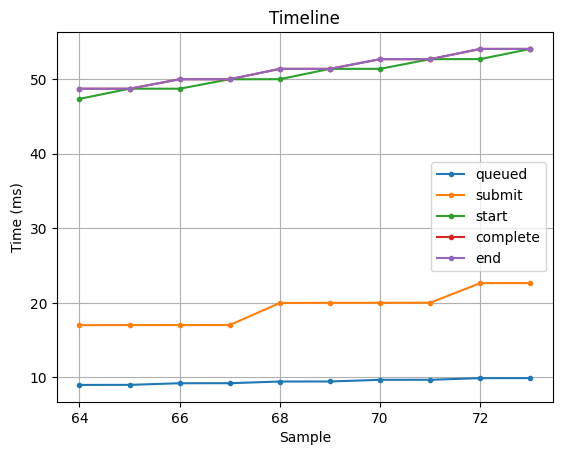

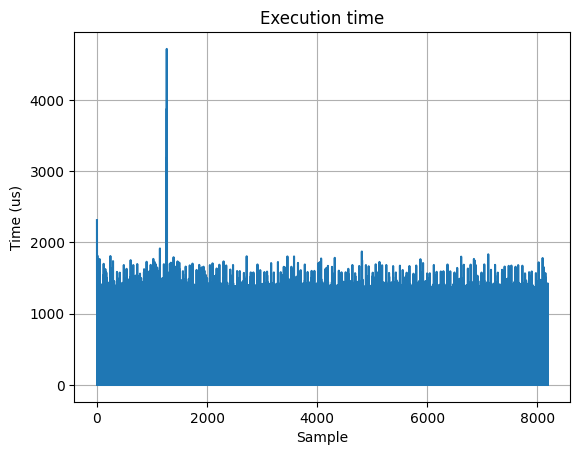

exec_median=623.460us


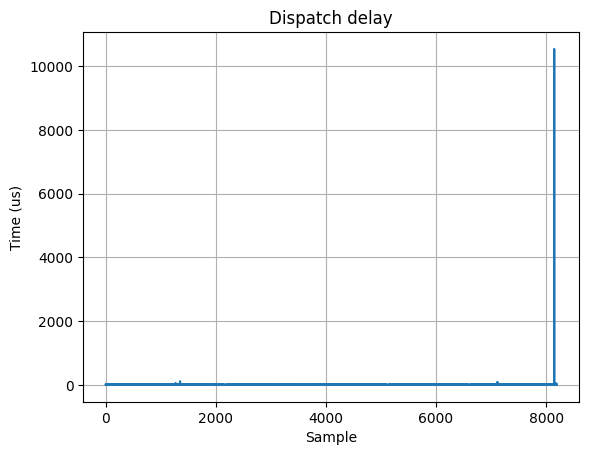

dispatch_delay_median=0.000us


In [10]:
def get_profiling_info(ev):
    keys = [
        "COMPLETE",
        "END",
        "QUEUED",
        "START",
        "SUBMIT",
    ]
    return { key.lower(): ev.get_profiling_info(getattr(cl.profiling_info, key)) for key in keys }
    
ns_per_tick = device_info["profiling_timer_resolution"]

profile_info = [get_profiling_info(ev) for _, ev in kernel_events]
event_types = list(profile_info[0].items())
event_types = sorted(event_types, key=lambda x: x[1])
event_types = [k for k,v in event_types]
print(event_types)

total_events = len(event_types)
N = len(profile_info)
Y = np.zeros((total_events, N), dtype=np.float64)
X = np.arange(len(profile_info))

for j, key in enumerate(event_types):
    y = Y[j]
    for i, info in enumerate(profile_info):
        time_ticks = info[key]
        time_ns = ns_per_tick*time_ticks
        y[i] = time_ns

Y -= np.min(Y)

plt.figure()
i = slice(64, 64+10)
# i = slice(0, N)
for j, key in enumerate(event_types):
    # if j <= 1: continue
    plt.plot(X[i], Y[j,i] * 1e-6, label=key, marker=".")
plt.grid(True)
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Time (ms)")
plt.title("Timeline")
plt.show()

exec_ns = Y[3] - Y[2]
plt.figure()
plt.plot(exec_ns*1e-3)
plt.grid()
plt.xlabel("Sample")
plt.ylabel(f"Time (us)")
plt.title("Execution time")
plt.show()

print(f"exec_median={np.median(exec_ns)*1e-3:.3f}us")

delay_dispatch_ns = Y[2,1:] - Y[3,:-1] 
plt.figure()
plt.plot(delay_dispatch_ns*1e-3)
plt.grid()
plt.xlabel("Sample")
plt.ylabel(f"Time (us)")
plt.title("Dispatch delay")
plt.show()

# print(f"dispatch_delay_median={np.median(delay_dispatch_ns)*1e-3:.3f}us")
print(f"dispatch_delay_median={np.median(delay_dispatch_ns)*1e-3:.3f}us")